In [1]:
from urllib.request import urlretrieve
import os, zipfile

forced = True

if not os.path.exists("./afrodb.zip") or forced:
    urlretrieve(
        ("https://coconut.s3.uni-jena.de/prod/downloads/2025-04/collections/afrodb-04-2025.zip"),
        "./afrodb.zip"
    )

if not os.path.exists("./afrodb.sdf") or forced:
    with zipfile.ZipFile("./afrodb.zip", "r") as zip_ref:
        zip_ref.extractall("./")
    os.rename("./afrodb-04-2025.sdf", "./afrodb.sdf")

with open(".gitignore", "w") as f:
    f.write("afrodb.zip\n")
    f.write("afrodb.sdf\n")

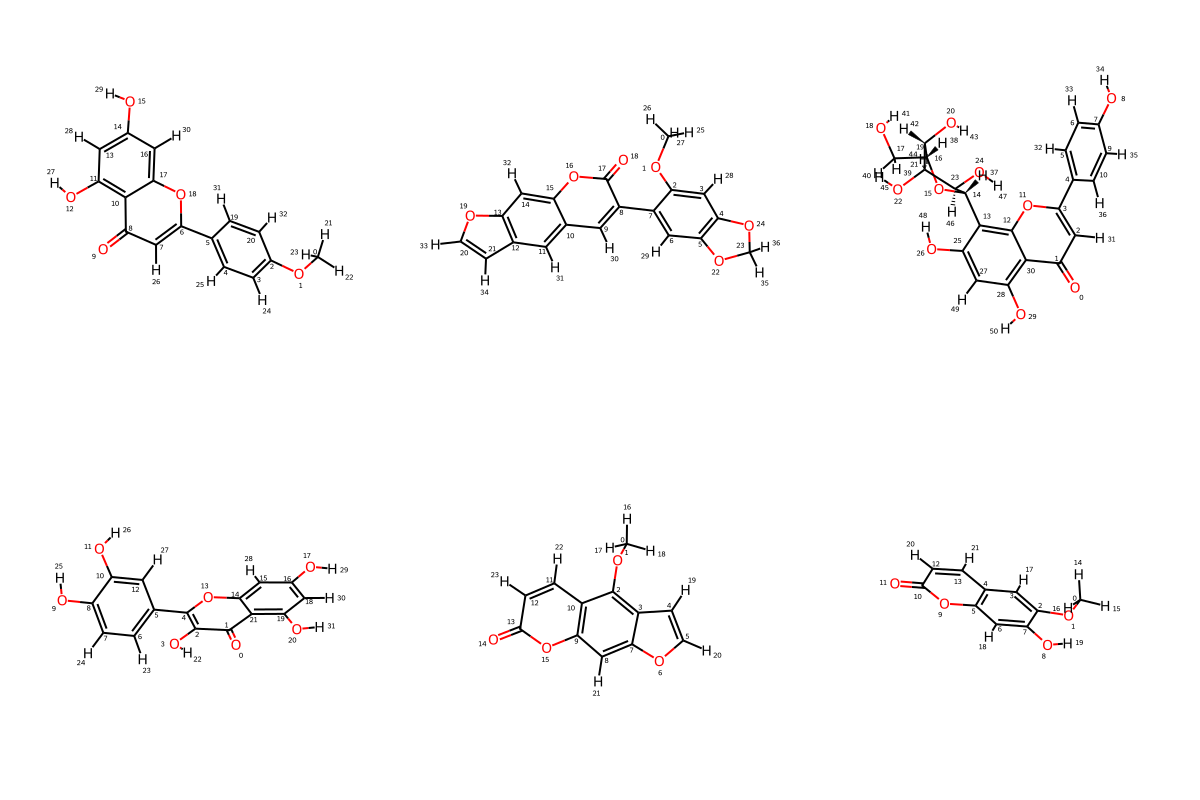

In [2]:
from rdkit import Chem
from rdkit.Chem import rdDistGeom, rdForceFieldHelpers
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = True

mols = list(Chem.SDMolSupplier("./afrodb.sdf"))[:100]
mols = [Chem.AddHs(m) for m in mols]
suc = [rdDistGeom.EmbedMolecule(m) for m in mols]
mols = [m for i, m in enumerate(mols) if suc[i] == 0]
[rdForceFieldHelpers.MMFFOptimizeMolecule(m) for m in mols]

IPythonConsole.ShowMols(mols[:6], molsPerRow=3, subImgSize=(400, 400))

In [3]:
from druglab.pharm import PharmGenerator, InternalStericAdjuster
import nglview as nv

idx = 97

pgen = PharmGenerator()
pharm = pgen.generate(mols[idx])

view1 = nv.show_rdkit(mols[idx])
pharm.draw(view1)

InternalStericAdjuster().adjust(pharm, mols[idx].GetConformer())
view2 = nv.show_rdkit(mols[idx])
pharm.draw(view2)

nv.widget.VBox([nv.show_rdkit(mols[idx]), view1, view2])

In [21]:
from druglab.pharm import PharmFFFProfiler

idx = 97

profiler = PharmFFFProfiler(pgen.ftypes)
adjuster = InternalStericAdjuster()

ref_mol = mols[idx]
ref_pharm = pgen.generate(ref_mol)
adjuster.adjust(ref_pharm, ref_mol.GetConformer())
ref_prof = profiler.profile(ref_pharm)

que_mols = [mols[i] for i in range(len(mols)) if i != idx]
que_pharms = [pgen.generate(m) for m in que_mols]
[adjuster.adjust(p, m.GetConformer()) for p, m in zip(que_pharms, que_mols)]
que_profs = [profiler.profile(p) for p in que_pharms]

import numpy as np

sorted_ids = np.flip(np.argsort(ref_prof.screen(que_profs, que_pharms)))

/home/arazthexd/projects/002_druglab/src/druglab/pharm/calculations.py:94: RuntimeWarning: invalid value encountered in divide
  v2 = v2 / np.linalg.norm(v2)


In [22]:
match_id = 1

view1 = nv.show_rdkit(ref_mol)
ref_pharm.draw(view1)

view2 = nv.show_rdkit(que_mols[sorted_ids[match_id]])
que_pharms[sorted_ids[match_id]].draw(view2)

nv.widget.VBox([nv.show_rdkit(ref_mol), 
                nv.show_rdkit(que_mols[sorted_ids[match_id]]), 
                view1, 
                view2])

In [23]:
diff = np.linalg.norm(ref_pharm.pos[:, None] - que_pharms[sorted_ids[match_id]].pos[None, :], 
                      axis=-1)
mask = ref_pharm.tyidx[:, None] == que_pharms[sorted_ids[match_id]].tyidx[None, :]
diff[~mask] = 1000

from scipy.optimize import linear_sum_assignment

linear_sum_assignment(diff)

(array([0, 1, 2, 3]), array([2, 1, 3, 4]))

In [ ]:
rv = ref_pharm.vec
qv = que_pharms[sorted_ids[match_id]]
(rv[:, None, :] * qv.vec[None, :, :]).sum(axis=-1) / 

(4, 5)

In [ ]:
.shape

(4, 1, 3)

ValueError: non-broadcastable output operand with shape (1,5,3) doesn't match the broadcast shape (4,5,3)

In [14]:
ref_pharm.orig_atids

[(7,), (16,), (2, 3, 4, 5, 14, 15), (2, 3, 4, 5, 14, 15)]

In [15]:
que_pharms[sorted_ids[match_id]].orig_atids

[(8,), (5,), (17,), (2, 3, 4, 6, 15, 16), (2, 3, 4, 6, 15, 16)]

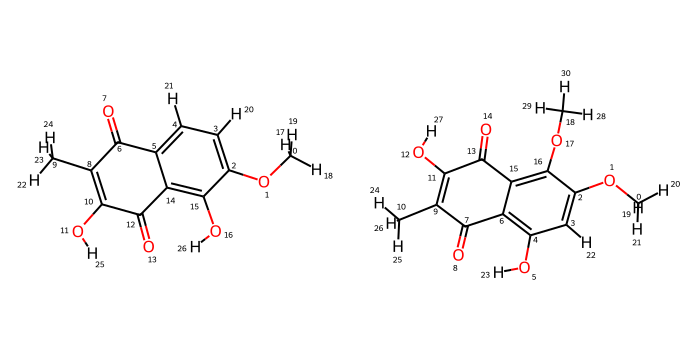

In [ ]:
IPythonConsole.ShowMols([ref_mol, que_mols[sorted_ids[match_id]]], molsPerRow=2, subImgSize=(350, 350))